In [105]:
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10

# Preprocess STL10 images by converting them from RGB to LAB
class RGB2LabTransform:
    def __call__(self, image):
        # Convert PyTorch tensor (C x H x W) to NumPy array (H x W x C)
        np_image = image.numpy().transpose(1, 2, 0)
        
        # Convert RGB to LAB using OpenCV
        lab_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2LAB)
        
        # Extract L channel and AB channels
        L_channel = lab_image[:, :, 0] / 255.0  # Normalize L channel to [0, 1]
        AB_channels = (lab_image[:, :, 1:] + 128) / 255.0  # Normalize AB channels to [0, 1]
        
        # Convert L and AB channels back to PyTorch tensors
        L_tensor = torch.tensor(L_channel).unsqueeze(0)  # Add channel dimension for L
        AB_tensor = torch.tensor(AB_channels).permute(2, 0, 1)  # Permute AB channels to (C, H, W)
        
        return L_tensor, AB_tensor

# Custom dataset class to handle STL10 data
class STL10ColorizationDataset(STL10):
    def __getitem__(self, index):
        # Get the original image from the parent class
        image, _ = super().__getitem__(index)
        
        # Apply the LAB transformation to the image
        L_channel, AB_channels = RGB2LabTransform()(image)
        
        return L_channel, AB_channels

# Define transformations for STL10 dataset (no need to apply RGB2Lab in transform)
transform = transforms.Compose([
    transforms.ToTensor()        # Convert PIL Image to tensor
])

# Load STL10 dataset
stl10_pretrain = STL10ColorizationDataset(root='./data', split='train+unlabeled', download=True, transform=transform)

# DataLoader to feed batches for training
pretrain_loader = DataLoader(stl10_pretrain, batch_size=32, shuffle=True)

# Example to test if the loader works as expected
for L_channel, AB_channels in pretrain_loader:
    print(f"L_channel shape: {L_channel.shape}, AB_channels shape: {AB_channels.shape}")
    break  # Just checking one batch


Files already downloaded and verified
L_channel shape: torch.Size([32, 1, 96, 96]), AB_channels shape: torch.Size([32, 2, 96, 96])


In [106]:
import torch.nn as nn
import torch

class Colorization(nn.Module):
    def __init__(self, backbone):
        super(Colorization, self).__init__()
        self.backbone = backbone

        self.colorization_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()  # Output should be in range [-1, 1]
        )
        
        # Upsampling to 96x96
        self.upsample = nn.Upsample(size=(96, 96), mode='bilinear', align_corners=False)
        
    def forward(self, L_channel):
        features = self.backbone(L_channel)

        AB_channels = self.colorization_head(features)
        AB_channels = self.upsample(AB_channels)
        return AB_channels
    

In [107]:
from torchvision.models import resnet18

backbone = resnet18(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2])

colorization_model = Colorization(backbone)

/Users/padmaprabagaran/dev/SSL-Project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/padmaprabagaran/dev/SSL-Project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
    print('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Use Apple's Metal (for M1/M2 Macs)
    print('mps')
else:
    device = torch.device("cpu") 
    print('cpu')

mps


In [109]:
colorization_model = colorization_model.to(device)

In [110]:
# Training loop
num_epochs = 15
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(colorization_model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    total_loss = 0.0  # Initialize total loss for this epoch
    num_batches = 0   # Keep track of the number of batches

    # Training loop for the current epoch
    for L_channel, AB_channels in pretrain_loader:
        # Move data to the same device as the model
        L_channel = L_channel.to(device)
        AB_channels = AB_channels.to(device)
        
        L_channel_rgb = L_channel.repeat(1, 3, 1, 1)  # Shape: [batch_size, 3, 96, 96]

        # Forward pass
        predicted_AB = colorization_model(L_channel_rgb)

        # Compute loss
        loss = criterion(predicted_AB, AB_channels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and count batches
        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    average_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/15], Loss: 0.0028
Epoch [2/15], Loss: 0.0024
Epoch [3/15], Loss: 0.0023
Epoch [4/15], Loss: 0.0023
Epoch [5/15], Loss: 0.0022
Epoch [6/15], Loss: 0.0021
Epoch [7/15], Loss: 0.0019
Epoch [8/15], Loss: 0.0018
Epoch [9/15], Loss: 0.0017
Epoch [10/15], Loss: 0.0016
Epoch [11/15], Loss: 0.0016
Epoch [12/15], Loss: 0.0015
Epoch [13/15], Loss: 0.0015
Epoch [14/15], Loss: 0.0014
Epoch [15/15], Loss: 0.0014


In [98]:
loss

tensor(0.0010, device='mps:0', grad_fn=<MseLossBackward0>)

In [111]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

def visualize_colorization(L_channel, predicted_AB, ground_truth_AB):
    batch_size = L_channel.shape[0]

    for i in range(batch_size):
        # Convert model's output (predicted_AB) to RGB for each sample in the batch
        colorized_image = lab_to_rgb(L_channel[i], predicted_AB[i])

        # Convert the ground truth to RGB for each sample
        ground_truth_rgb = lab_to_rgb(L_channel[i], ground_truth_AB[i])

        # Display the colorized image and the ground truth (visualization code)
        plt.subplot(1, 2, 1)
        plt.imshow(colorized_image)
        plt.title('Predicted Colorization')

        plt.subplot(1, 2, 2)
        plt.imshow(ground_truth_rgb)
        plt.title('Ground Truth')

        plt.show()
        print(f"Predicted AB min: {predicted_AB[i].min():.2f}, max: {predicted_AB[i].max():.2f}")
        print(f"Ground Truth AB min: {ground_truth_AB[i].min():.2f}, max: {ground_truth_AB[i].max():.2f}")

# Convert LAB to RGB
def lab_to_rgb(L_channel, AB_channels):
    # Ensure L_channel has shape [96, 96] and scale it appropriately
    L_channel = L_channel.squeeze().cpu().numpy() * 255
    L_channel = L_channel 

    # Ensure AB_channels has shape [2, 96, 96] and transpose it to [96, 96, 2]
    AB_channels = AB_channels.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    AB_channels = (AB_channels * 255) - 128

    # Concatenate L and AB channels to form LAB image
    lab_image = np.concatenate((L_channel[:, :, np.newaxis], AB_channels), axis=-1)

    # Convert LAB to RGB using a library like skimage
    rgb_image = color.lab2rgb(lab_image)
    
    return rgb_image


In [112]:
print(L_channel.shape)
print(predicted_AB.shape)
print(AB_channels.shape)


torch.Size([8, 1, 96, 96])
torch.Size([8, 2, 96, 96])
torch.Size([8, 2, 96, 96])


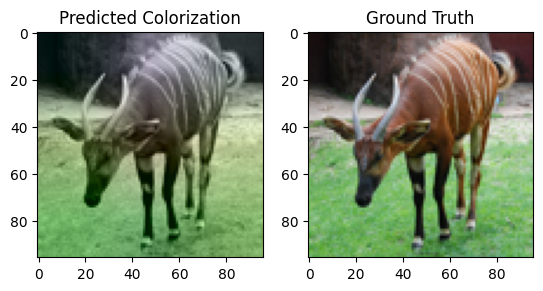

Predicted AB min: 0.36, max: 0.63
Ground Truth AB min: 0.32, max: 0.74


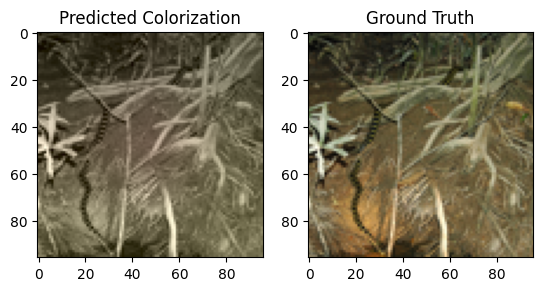

Predicted AB min: 0.49, max: 0.57
Ground Truth AB min: 0.40, max: 0.70


/var/folders/rw/35py9_rs1z90r14f5srqkfg40000gn/T/ipykernel_23224/2688519810.py:42: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  rgb_image = color.lab2rgb(lab_image)


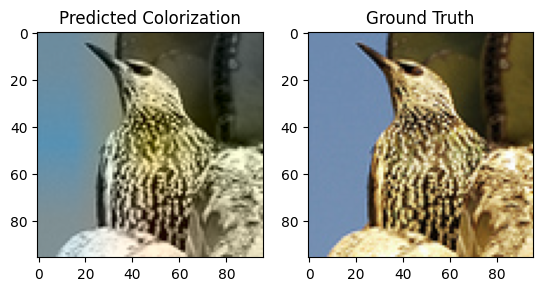

Predicted AB min: 0.41, max: 0.67
Ground Truth AB min: 0.37, max: 0.72


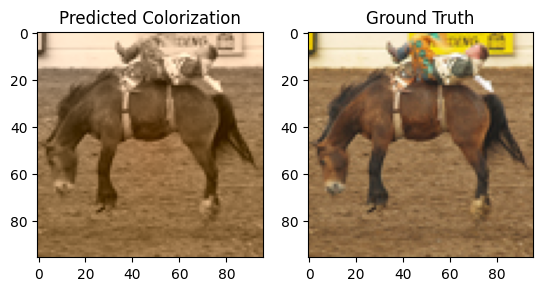

Predicted AB min: 0.52, max: 0.63
Ground Truth AB min: 0.33, max: 0.85


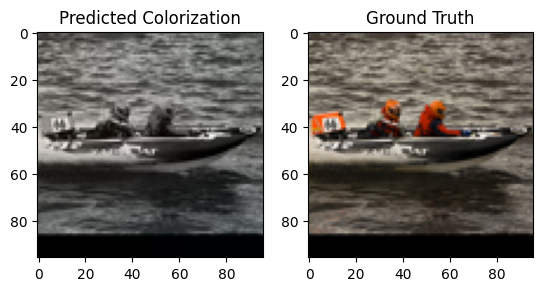

Predicted AB min: 0.50, max: 0.52
Ground Truth AB min: 0.39, max: 0.78


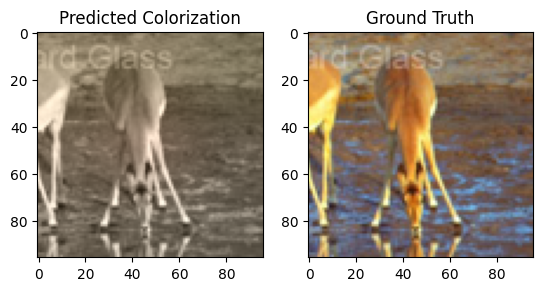

Predicted AB min: 0.50, max: 0.57
Ground Truth AB min: 0.35, max: 0.80


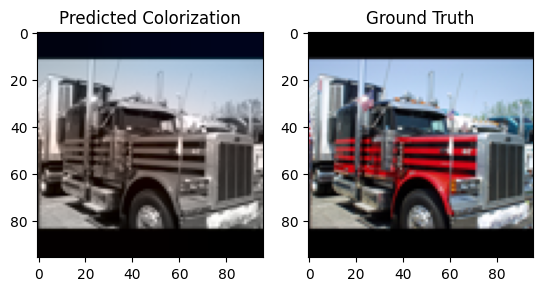

Predicted AB min: 0.44, max: 0.54
Ground Truth AB min: 0.33, max: 0.78


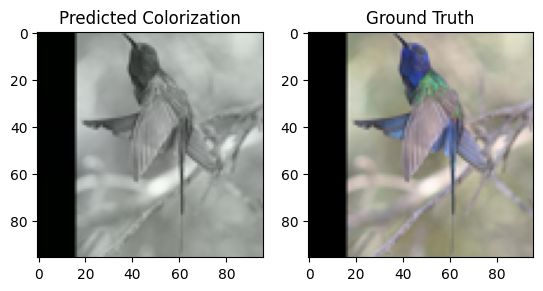

Predicted AB min: 0.49, max: 0.51
Ground Truth AB min: 0.28, max: 0.62


In [113]:
visualize_colorization(L_channel, predicted_AB, AB_channels)


## Downstream Classification

In [124]:
for param in colorization_model.backbone.parameters():
    param.requires_grad = False

In [125]:
class ClassificationNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(ClassificationNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((1, 1))(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        output = self.classifier(pooled_features)
        return output

classification_model = ClassificationNet(colorization_model.backbone, num_classes=10).to(device)

In [120]:
classification_transform = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # RGB for classification
])

In [127]:
stl10_train = STL10(root='path_to_data', split='train', download=True, transform=classification_transform)
stl10_test = STL10(root='path_to_data', split='test', download=True, transform=classification_transform)

# Fine-tuning: Load training data for classification task
train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True)

# Testing: Load test data for final evaluation
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [128]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(classification_model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    classification_model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classification_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Evaluation
classification_model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Epoch [1/200], Loss: 1.6122
Epoch [2/200], Loss: 1.6056
Epoch [3/200], Loss: 1.6107
Epoch [4/200], Loss: 1.6119
Epoch [5/200], Loss: 1.6051
Epoch [6/200], Loss: 1.6000
Epoch [7/200], Loss: 1.6069
Epoch [8/200], Loss: 1.6062
Epoch [9/200], Loss: 1.6181
Epoch [10/200], Loss: 1.6012
Epoch [11/200], Loss: 1.6073
Epoch [12/200], Loss: 1.6086
Epoch [13/200], Loss: 1.6115
Epoch [14/200], Loss: 1.6080
Epoch [15/200], Loss: 1.5962
Epoch [16/200], Loss: 1.6082
Epoch [17/200], Loss: 1.5951
Epoch [18/200], Loss: 1.5937
Epoch [19/200], Loss: 1.6036
Epoch [20/200], Loss: 1.6125
Epoch [21/200], Loss: 1.5990
Epoch [22/200], Loss: 1.6329
Epoch [23/200], Loss: 1.6056
Epoch [24/200], Loss: 1.6114
Epoch [25/200], Loss: 1.6006
Epoch [26/200], Loss: 1.6135
Epoch [27/200], Loss: 1.6063
Epoch [28/200], Loss: 1.6020
Epoch [29/200], Loss: 1.5950
Epoch [30/200], Loss: 1.6095
Epoch [31/200], Loss: 1.6190
Epoch [32/200], Loss: 1.6100
Epoch [33/200], Loss: 1.5976
Epoch [34/200], Loss: 1.6007
Epoch [35/200], Loss: 1